# Workshop Time Series

In this workshop you will practice performing time series analysis.

Lesson goal: The student applies time series forecasting techniques to make predictions using a time series data set. This lesson goal relates to final qualification "data analytics".


We will be using a dataset containing energy consumption data for a heat pump. It contains the following columns:

- timestamp: timestamp
- E_apparaten: energy use of other devices in kWh
- E_warmtepomp: energy use of heatpump in kWh
- E_verbruik: total energy use in kWh
- Overschot: energy returned to grid
- hp_AAN: heatpump on or off
- diff_temp_woonk: temperature living room
- diff_temp_slaapk: temperature bedroom
- Tussendeur: inside door open / closed
- Buitendeur: outside door open / closed
- Raam: window open / closed
- Dag: weekday
- day_of_week: weekday (same as "Dag")
- month: month
- year: year

In this workshop we will focus on the E_warmtepomp column

In [37]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import acf
from scipy.signal import savgol_filter, butter, filtfilt
from statsmodels.tsa.seasonal import seasonal_decompose


In [ ]:
# Read in the data
dfhp = pd.read_csv("data/heatpump_clean_filtered.csv")
dfhp['timestamp_dt'] = pd.to_datetime(dfhp['timestamp']) # Create a copy of the timestamp that is converted to a proper date time stamp object so Python can analyze it better.
dfhp

,timestamp,E_apparaten,E_warmtepomp,E_verbruik,overschot,hp_AAN,diff_temp_woonk,diff_temp_slaapk,Tussendeur,Buitendeur,Raam,Dag,day_of_week,month,year,timestamp_dt
0,2019-11-30 21:00:00,0.000000,0.000000,0.000000,0.000000,0.0,19.300000,17.800000,1.0,0.0,0.0,5,5,11,2019,2019-11-30 21:00:00
1,2019-11-30 21:30:00,0.012299,0.455955,0.468254,0.000000,1.0,19.594167,18.094167,1.0,0.0,0.0,5,5,11,2019,2019-11-30 21:30:00
2,2019-11-30 22:00:00,0.012543,0.464996,0.477539,0.000000,1.0,20.286389,18.884444,1.0,0.0,0.0,5,5,11,2019,2019-11-30 22:00:00
3,2019-11-30 22:30:00,0.023764,0.538520,0.562284,0.000000,1.0,20.790278,19.390278,1.0,0.0,0.0,5,5,11,2019,2019-11-30 22:30:00
4,2019-11-30 23:00:00,0.085571,0.608624,0.694196,0.000000,1.0,19.427222,18.223333,1.0,0.0,0.0,5,5,11,2019,2019-11-30 23:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10244,2020-07-01 07:00:00,0.102798,0.002612,0.105410,0.000000,1.0,6.000000,6.600000,0.0,0.0,0.0,2,2,7,2020,2020-07-01 07:00:00
10245,2020-07-01 07:30:00,0.092111,0.010005,0.102116,0.000000,1.0,5.947889,6.521833,0.0,0.0,0.0,2,2,7,2020,2020-07-01 07:30:00
10246,2020-07-01 08:00:00,0.093163,0.007402,0.100565,0.001018,1.0,5.800000,6.300000,0.0,0.0,0.0,2,2,7,2020,2020-07-01 08:00:00
10247,2020-07-01 08:30:00,0.088124,0.002610,0.090734,0.034967,1.0,5.646187,6.146187,0.0,0.0,0.0,2,2,7,2020,2020-07-01 08:30:00


As there are 100,000 rows for our initial experiments for our first analyses we will summarize them or zoom on sub selections to avoid having to spend too much time waiting for calculations to complete. Later on you will work on the full data set.

For starters, lets sum the E_warmptepomp data for each day. Then plot the contents to see what we're dealing with.

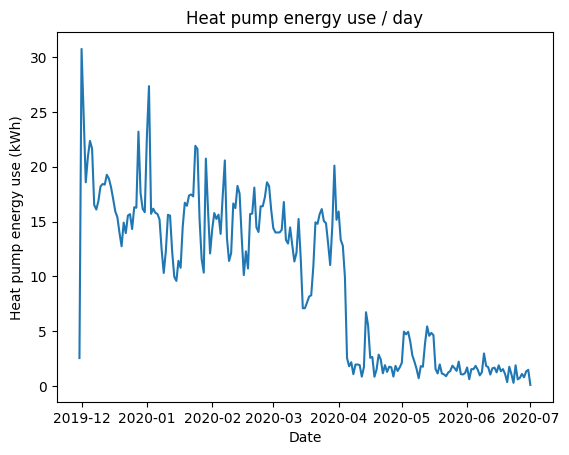

In [24]:
# To be able to sum by day we need to create a column that contains the day only.
# Note we use the to_datetime function to convert the date string to something
# that Python recognizes as a date object.
dfhp['datum'] = pd.to_datetime(dfhp['timestamp'].replace(' .*$', '', regex=True))
# Now sum the E_warmtepomp values for each day. Reset the index to obtain a dataframe instead of a groupby object.
df_sum = dfhp[['datum', 'E_warmtepomp']].groupby(by='datum').sum().reset_index()

plt.plot(df_sum['datum'], df_sum['E_warmtepomp'])
plt.title('Heat pump energy use / day')
plt.ylabel('Heat pump energy use (kWh)')
plt.xlabel('Date')
plt.show()



Clearly there are some interesting things going on with the data. For our first experiments, these are inconvenient, however, so let's first zoom in on a sub selection of data, say from 2020-01-01 to 2020-04-01

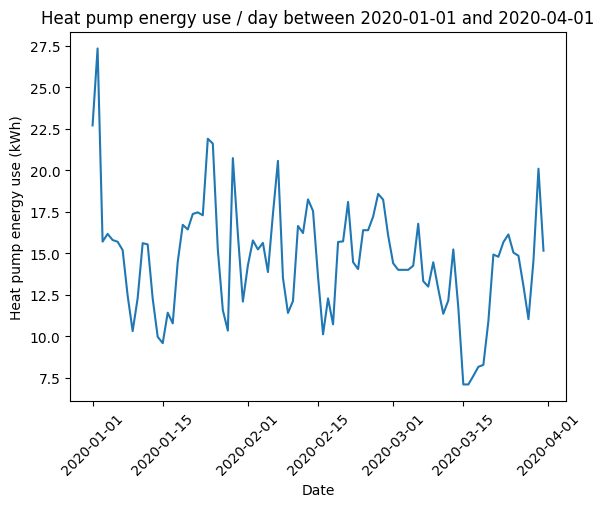

In [29]:
df_sum_sel = df_sum[(df_sum['datum'] >= '2020-01-01') & (df_sum['datum'] < '2020-04-01')]
plt.plot(df_sum_sel['datum'], df_sum_sel['E_warmtepomp'])
plt.title('Heat pump energy use / day between 2020-01-01 and 2020-04-01')
plt.ylabel('Heat pump energy use (kWh)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.show()

There does not seem to be an obvious pattern here. Let's create an autocorrelation function plot to see if this intuition is correct.

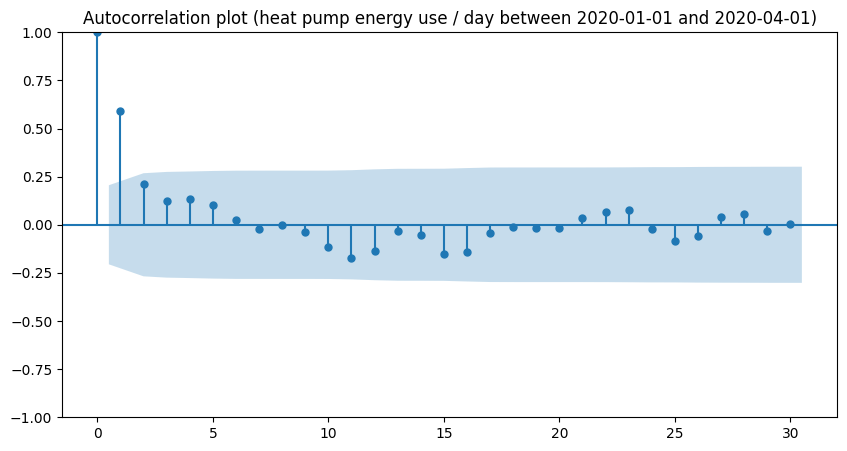

In [36]:
acf_plot = tsaplots.plot_acf(df_sum_sel["E_warmtepomp"], lags=30, title='Autocorrelation plot (heat pump energy use / day between 2020-01-01 and 2020-04-01)')

# Adjust the plot size
acf_plot.set_figheight(5)
acf_plot.set_figwidth(10)

# Show the plot
plt.show()

Autocorrelation is extremely weak, confirming our intuition that there is no obvious repeating pattern in the data.

However, there may be a seasonal effect in the data, albeit a weak one. Can you spot it?

Let's see if decomposition makes the effect more obvious.

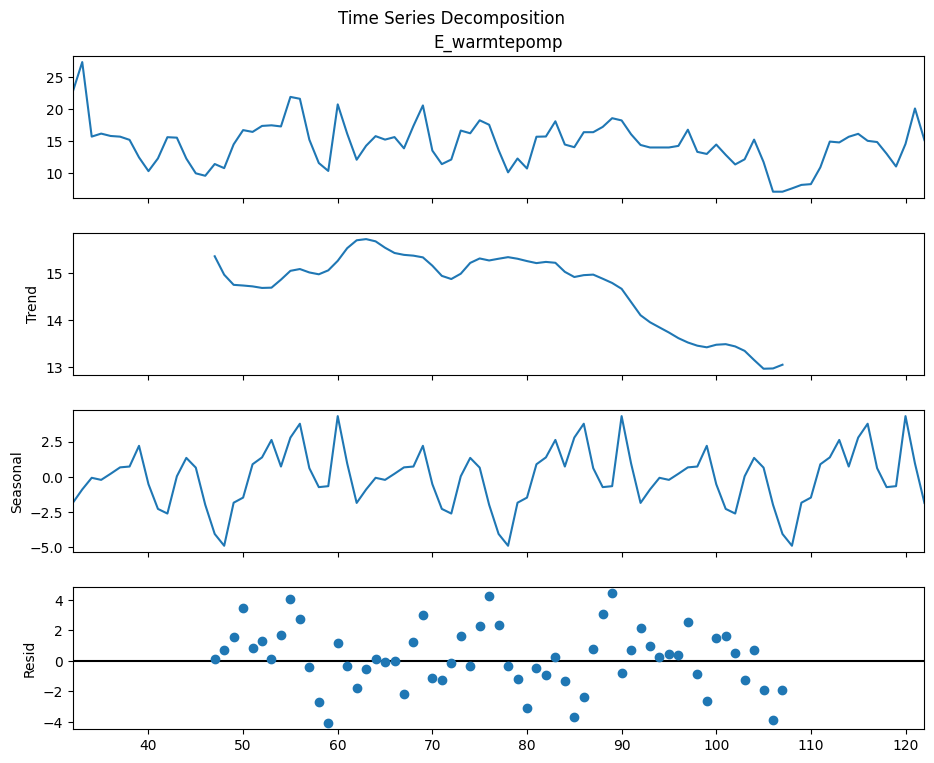

In [39]:

# Decompose the time series
result = seasonal_decompose(df_sum_sel["E_warmtepomp"], model="additive", period=30)

# Plot the decomposed components
decomposed = result.plot()

decomposed.set_figheight(8)
decomposed.set_figwidth(10)
decomposed.suptitle("Time Series Decomposition")

plt.show()

There seems to be a clear, albeit small, trend in the data. Perhaps filtering would make this effect more obvious?

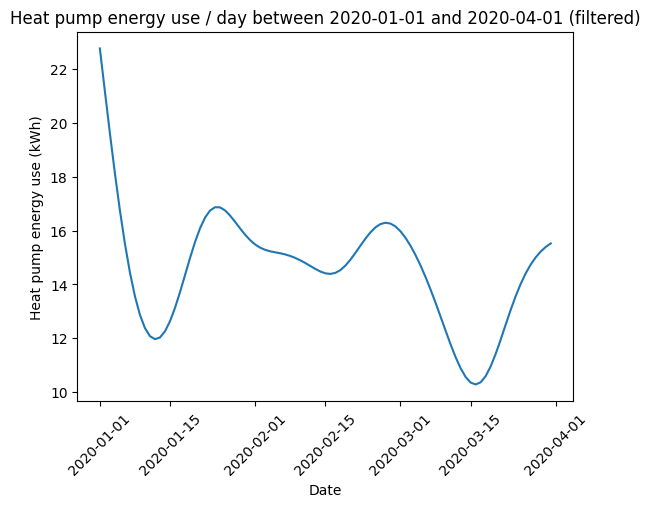

In [56]:
cutoff_frequency = 0.1  # Cutoff frequency as a fraction of the sampling rate
filter_order = 3  # Filter order
b, a = butter(filter_order, cutoff_frequency, btype="low", analog=False)
butterworth_filtered = filtfilt(b, a, df_sum_sel['E_warmtepomp'])

plt.plot(df_sum_sel['datum'], butterworth_filtered)
plt.title('Heat pump energy use / day between 2020-01-01 and 2020-04-01 (filtered)')
plt.ylabel('Heat pump energy use (kWh)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.show()

Play around with the cutoff_frequency parameter to see if you can make the effect more pronounced.

## Try it yourself: analyze the full data set

Now try it yourself. Using the complete data set, analyse it for seasonality and trends. Make sure to use the dfhp['timestamp_ts'] column for the timestamp.

Play around with the values for the lags parameter and the period parameter

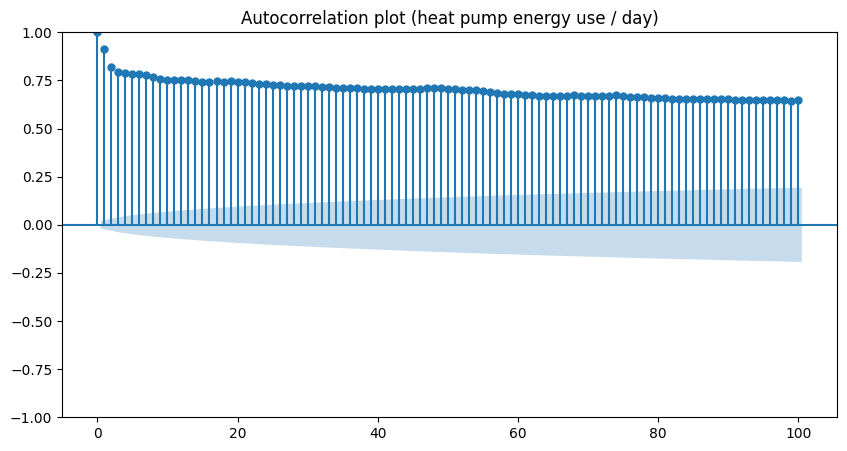

In [ ]:
# Your code for the ACF plot goes here. Try changing the lags parameter.



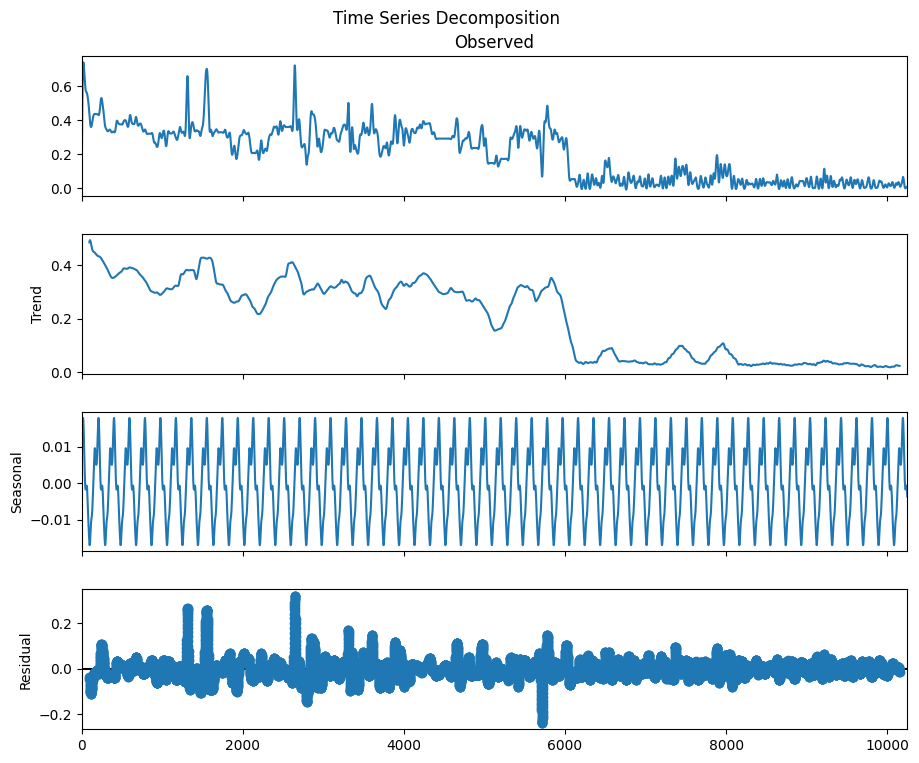

In [ ]:
# Your code for the decomposition goes here. Be sure to try changing the period parameter.
# If you have time, try filtering the data before decomposing it.


plt.show()